In [71]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, Birch, AffinityPropagation
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
sns.set_style('darkgrid')

import os

# 画图函数

In [72]:
def merge(dfs, title, xlabel="K-value", ylabel="adjusted rand score"):
    df = pd.concat(dfs, axis=1)
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    sns.lineplot(data = df)

In [73]:
def plot_line(title:str, y:list, x:list, line_name:str, xlabel="K-value", ylabel="adjusted rand score"):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    df = pd.DataFrame({line_name: y}, index=x)
    sns.lineplot(data = df)
    
    return df

In [74]:
def plot_count(title:str, x:list, line_name:str, xlabel="K-value", ylabel="adjusted rand score"):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    df = pd.DataFrame({xlabel: x})
    sns.countplot(x=xlabel, data = df)
    
    return df

# 聚类函数

In [96]:
def k_means_clustering(data, labels, title="", start=2, end=10):
    scores = []
    ks = []
    for i in range(start, end+1):
        ks.append(i)
        pre = KMeans(n_clusters=i).fit_predict(data)
        score = adjusted_rand_score(labels, pre)
        print("adjusted rand score is {:.4f} while k = {}".format(score, i))
        scores.append(score)    
    df = plot_line(title, scores, ks, "KMeans " + title)
    return df

In [110]:
def dbscan_clustering_min_samples(data, labels, stride=1, title="", start=2, end=10):
    scores = []
    mss = []
    for i in range(start, end+1, stride):
        mss.append(i)
        pre = DBSCAN(min_samples=i).fit_predict(data)
        d = pd.DataFrame(pre, columns=['cls'])
        n_cls = len(d.cls.unique())
        score = adjusted_rand_score(labels, pre)
        print("ARS is {:.4f} , {} clusters, while min_samples = {}".format(score,n_cls, i))
        scores.append(score)    
    df = plot_line(title, scores, mss, "DBSCAN " + title)
    return df

In [98]:
def dbscan_clustering_eps(data, labels, min_samples, title="", start=1, end=13):
    scores = []
    mss = []
    for i in [t/10 for t in range(start, end+1)]:
        mss.append(i)
        pre = DBSCAN(min_samples=min_samples, eps=i).fit_predict(data)
        d = pd.DataFrame(pre, columns=['cls'])
        n_cls = len(d.cls.unique())
        score = adjusted_rand_score(labels, pre)
        print("ARS is {:.4f} , {} clusters, while eps = {}".format(score,n_cls, i))
        scores.append(score)    
    df = plot_line(title, scores, mss, "DBSCAN " + title)
    return df

In [118]:
def birch_clustering_threshold(data, labels, n_clusters=10, title="", start=1, end=10):
    scores = []
    mss = []
    for i in [t/10 for t in range(start, end+1)]:
        mss.append(i)
        pre = Birch(n_clusters=n_clusters, threshold=i).fit_predict(data)
        d = pd.DataFrame(pre, columns=['cls'])
        n_cls = len(d.cls.unique())
        score = adjusted_rand_score(labels, pre)
        print("ARS is {:.4f} , {} clusters, while threshold = {}".format(score,n_cls, i))
        scores.append(score)    
    df = plot_line(title, scores, mss, "BIRCH " + title, xlabel="threshold")
    return df

In [115]:
def birch_clustering_branching_factor(data, labels, n_clusters=10,threshold=0.5, title="", start=40, end=60):
    scores = []
    mss = []
    for i in range(start, end+1):
        mss.append(i)
        pre = Birch(n_clusters=n_clusters, threshold=1, branching_factor=i).fit_predict(data)
        d = pd.DataFrame(pre, columns=['cls'])
        n_cls = len(d.cls.unique())
        score = adjusted_rand_score(labels, pre)
        print("ARS is {:.4f} , {} clusters, while branching factor = {}".format(score,n_cls, i))
        scores.append(score)    
    df = plot_line(title, scores, mss, "BIRCH " + title, xlabel="branch_factor")
    return df

In [101]:
def ap_clustering(data, labels, title="", start=-60, end=-40):
    scores = []
    mss = []
    for i in range(start, end+1):
        mss.append(i)
        pre = AffinityPropagation(preference=i).fit_predict(data)
        d = pd.DataFrame(pre, columns=['cls'])
        n_cls = len(d.cls.unique())
        score = adjusted_rand_score(labels, pre)
        print("ARS is {:.4f} , {} clusters, while eps = {}".format(score,n_cls, i))
        scores.append(score)    
    df = plot_line(title, scores, mss, "AP " + title, xlabel="preference")
    return df

# 准备工作
## 弃用的保存图片函数

In [80]:
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')
 
 
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## CNN模型

In [81]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )
 
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 超参数

In [82]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

## 数据集

In [83]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 模型实例，损失函数，优化器

In [84]:
model = AutoEncoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [85]:
model.load_state_dict(torch.load("./conv_autoencoder.pth"))

<All keys matched successfully>

# 数据预处理

In [86]:
model.eval()
data_arr = None
label_arr = None
for batch_id, data in enumerate(dataloader):
    # 加载数据
    image, target = data
    image = image.cuda()
    # 图像降维
    out = model.encoder(image)
    # 图像展开为32维向量
    out = out.cpu().detach().numpy()
    n_samples = out.shape[0]
    out = out.reshape(n_samples, -1)
    # 标签展开为向量
    target = target.detach().numpy()
    # 保存图像数据和标签数据
    if batch_id == 0:
        data_arr = out
        label_arr = target
    else:
        data_arr = np.concatenate((data_arr, out), axis=0)
        label_arr = np.concatenate((label_arr, target), axis=0)

# 聚类
## K-Means

adjusted rand score is 0.2701 while k = 6
adjusted rand score is 0.3194 while k = 7
adjusted rand score is 0.2877 while k = 8
adjusted rand score is 0.3014 while k = 9
adjusted rand score is 0.2948 while k = 10
adjusted rand score is 0.2923 while k = 11
adjusted rand score is 0.2967 while k = 12


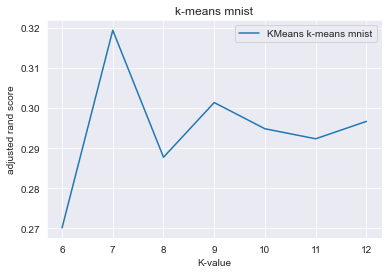

In [89]:
_ = k_means_clustering(data_arr, label_arr, "k-means mnist", start=6, end=12)

## DBSCAN
### min_sample

ARS is 0.0000 , 1 clusters, while min_samples = 500
ARS is 0.0000 , 1 clusters, while min_samples = 600
ARS is 0.0000 , 1 clusters, while min_samples = 700
ARS is 0.0000 , 1 clusters, while min_samples = 800
ARS is 0.0000 , 1 clusters, while min_samples = 900
ARS is 0.0000 , 1 clusters, while min_samples = 1000
ARS is 0.0000 , 1 clusters, while min_samples = 1100
ARS is 0.0000 , 1 clusters, while min_samples = 1200


,DBSCAN MNIST
500,0.0
600,0.0
700,0.0
800,0.0
900,0.0
1000,0.0
1100,0.0
1200,0.0


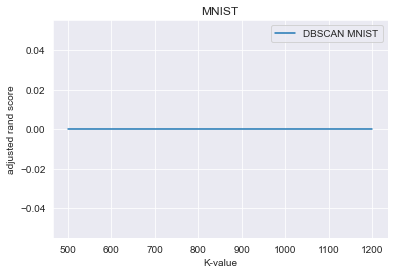

In [112]:
dbscan_clustering_min_samples(data_arr[:10000], label_arr[:10000], stride=100,title="MNIST", start=500, end=1200)

## BIRCH
### threshold

ARS is 0.3740 , 10 clusters, while threshold = 1.0
ARS is 0.3684 , 10 clusters, while threshold = 1.1
ARS is 0.2907 , 10 clusters, while threshold = 1.2
ARS is 0.3412 , 10 clusters, while threshold = 1.3
ARS is 0.2967 , 10 clusters, while threshold = 1.4
ARS is 0.3127 , 10 clusters, while threshold = 1.5


,BIRCH MNIST
1.0,0.374014
1.1,0.368408
1.2,0.290742
1.3,0.341168
1.4,0.296749
1.5,0.312690


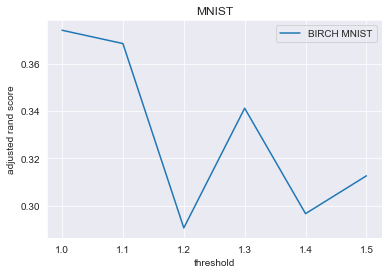

In [120]:
birch_clustering_threshold(data_arr[:10000], label_arr[:10000], title="MNIST", start=10, end=15)

### branching_factor

ARS is 0.3027 , 10 clusters, while branching factor = 40
ARS is 0.2751 , 10 clusters, while branching factor = 41
ARS is 0.4049 , 10 clusters, while branching factor = 42
ARS is 0.3673 , 10 clusters, while branching factor = 43
ARS is 0.3679 , 10 clusters, while branching factor = 44
ARS is 0.3823 , 10 clusters, while branching factor = 45
ARS is 0.3608 , 10 clusters, while branching factor = 46
ARS is 0.3090 , 10 clusters, while branching factor = 47
ARS is 0.3882 , 10 clusters, while branching factor = 48
ARS is 0.3765 , 10 clusters, while branching factor = 49
ARS is 0.3740 , 10 clusters, while branching factor = 50
ARS is 0.3597 , 10 clusters, while branching factor = 51
ARS is 0.4058 , 10 clusters, while branching factor = 52
ARS is 0.3068 , 10 clusters, while branching factor = 53
ARS is 0.4217 , 10 clusters, while branching factor = 54
ARS is 0.3984 , 10 clusters, while branching factor = 55
ARS is 0.3131 , 10 clusters, while branching factor = 56
ARS is 0.3379 , 10 clusters, wh

,BIRCH MNIST
40,0.302700
41,0.275111
42,0.404933
43,0.367316
44,0.367863
45,0.382333
46,0.360785
47,0.308973
48,0.388197
49,0.376461


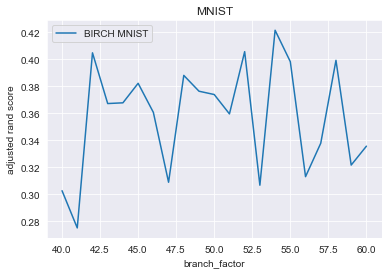

In [121]:
birch_clustering_branching_factor(data_arr[:10000], label_arr[:10000], title="MNIST", threshold=0.1)

C:\Users\airan\Anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)
ARS is 0.1200 , 108 clusters, while eps = -60
C:\Users\airan\Anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_affinity_propagation.py:152: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning)
ARS is 0.1200 , 108 clusters, while eps = -59
C:\Users\airan\Anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_affinity_propagation.py:152: FutureWarning: 'random_state' has been intro

,AP MNIST
-60,0.119992
-59,0.119992
-58,0.120225
-57,0.118445
-56,0.116623
-55,0.117154
-54,0.114663
-53,0.113151
-52,0.109392
-51,0.104670


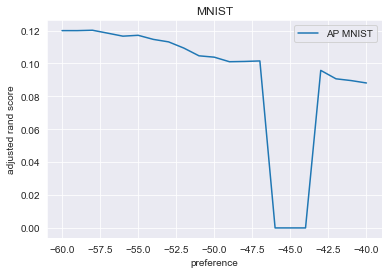

In [123]:
ap_clustering(data_arr[:1000], label_arr[:1000], "MNIST")

In [93]:
data_arr[:10000].shape

(10000, 32)